# Customer Classification using E-Commerce Dataset


## About Dataset
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Aim
We aim to implement various classification algorithms like SVM, Logistic Regression, Naive Bayes, Random Forest, SGD, k-NN to predict a customer's origin and to compare the performance of these supervised machine learning models.

### 1. Data Processing

In [115]:
#Importing necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [116]:
#Loading dataset
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')

In [117]:
#Function to display information about the dataset
def information(df):
    print(df.describe())
    print(df.dtypes)
    print(df.head())

def shape(df):
    print(df.shape)

In [79]:
# Displaying data set information
print(shape(df))
# print(information(df)

(541909, 8)
None


In [118]:
#Extracting Year, Month, Day and Hour from TimeStamp
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month 
df['Day'] = df['InvoiceDate'].dt.day 
df['Hour'] = df['InvoiceDate'].dt.hour 

In [119]:
#Check missing values for each column
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Hour                0
Day                 0
Month               0
Year                0
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [120]:
# Drop duplicates by keeping the first value
df.drop_duplicates(keep='first', inplace=True)
shape(df)

(536641, 12)


In [121]:
# Drop Invoice Date since values extracted
df.drop(columns=['InvoiceDate'], inplace=True)
shape(df)

(536641, 11)


### 2. Exploratory Data Analysis

#### Exploring the content of variables

This dataframe contains 8 variables that correspond to:
<br><br>
__InvoiceNo:__ Invoice number. Nominal - A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. <br>
__StockCode:__ Product code. Nominal - A 5-digit integral number uniquely assigned to each distinct product.<br>
__Description:__ Product (item) name. Nominal. 
<br>
__Quantity:__ Numeric - The quantities of each product (item) per transaction. <br>
__InvoiceDate:__ Invice Date and time. Numeric - The day and time when each transaction was generated. <br>
__UnitPrice:__ Unit price. Numeric - Price per unit of the product <br>
__CustomerID:__ Customer number. Nominal - A 5-digit integral number uniquely assigned to each customer. <br>
__Country:__ Country name. Nominal - The name of the country where each customer resides.<br>

In [122]:
#Count the total number of countries - y label - multi-class classification with 37 classes
print(df['Country'].nunique())
print(df['Description'].nunique())
print(df['StockCode'].nunique())
print(df['InvoiceNo'].nunique())
print(df['CustomerID'].nunique())

38
4223
4070
25900
4372


In [123]:
#We now add another variable - Total Price for better EDA
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
shape(df)

(536641, 12)


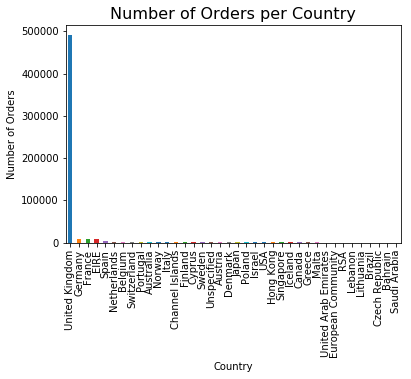

In [124]:
# Number of orders made by each country
total_orders=df.groupby('Country')['Quantity'].count().sort_values(ascending=False)
total_orders.plot('bar')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Country', fontsize=16)
plt.show()

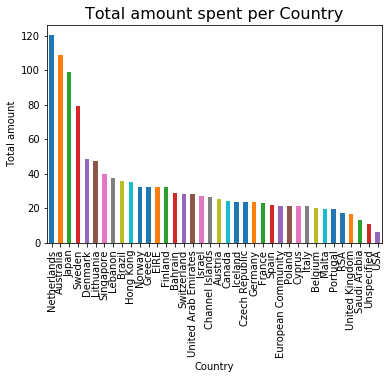

In [125]:
#Total amount spent per country
total_amount=df.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False)
total_amount.plot('bar')
plt.xlabel('Country')
plt.ylabel('Total amount')
plt.title('Total amount spent per Country', fontsize=16)
plt.show()

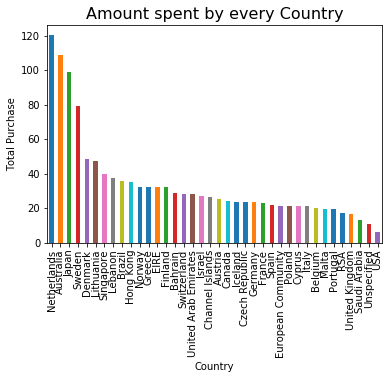

In [126]:
#Mean amount spent per country plot
mean_amount=df.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False)
mean_amount.plot('bar')
plt.xlabel('Country')
plt.ylabel('Total Purchase')
plt.title('Amount spent by every Country', fontsize=16)
plt.show()

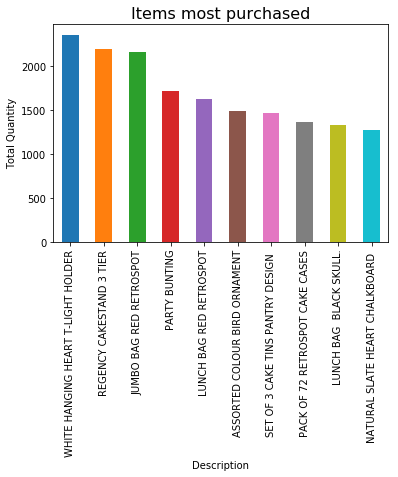

In [134]:
high_descrip = df.groupby('Description')['Quantity'].count().sort_values(ascending=False)[:10]
high_descrip.plot('bar')
plt.xlabel('Description')
plt.ylabel('Total Quantity')
plt.title('Items most purchased', fontsize=16)
plt.show()

In [135]:
#Assign numbers categorically to each unique description 
df['Description'] = pd.Categorical(df['Description'])
df['Description_Code'] = df['Description'].cat.codes
df.drop(columns=['Description'], inplace=True)

In [136]:
#Assign numbers categorically to each unique description  
df['Country'] = pd.Categorical(df['Country'])
df['Country_Code'] = df['Country'].cat.codes
df.drop(columns=['Country'], inplace=True)

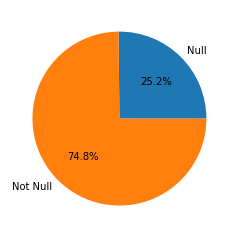

In [137]:
# Analysing the percentage of not null customers in the dataset. Inference - 25.2% Null, 74.8% Not Null
CustomerID_notnull = df.loc[~df['CustomerID'].isnull()] 
CustomerID_null = df.loc[df['CustomerID'].isnull()] 

pie_data = []
pie_data.append(len(CustomerID_null))
pie_data.append(len(CustomerID_notnull))
plt.pie(pie_data, labels=['Null', 'Not Null'], autopct='%1.1f%%',)
plt.show()

In [138]:
# To find from which country the maximum number of Null occurs
CustomerID_null.groupby(['Country_Code']).size().sort_values(ascending=False)

Country_Code
36    133572
10       709
16       284
37       201
33       117
13        66
18        47
27        39
2          2
dtype: int64

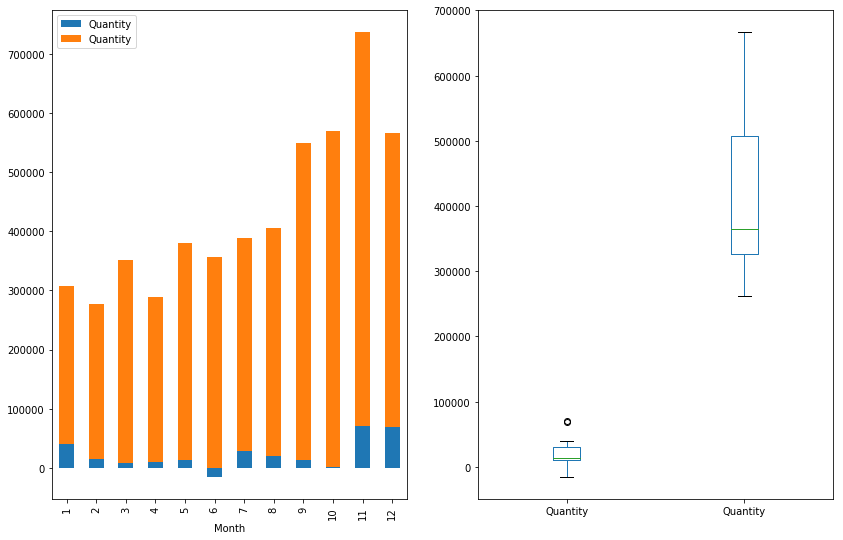

In [139]:
#To find the ratio of quantity of units purchased by null & not null customers
month_null = (CustomerID_null.groupby(['Month'])['Quantity'].sum())
month_notnull  = (CustomerID_notnull.groupby(['Month'])['Quantity'].sum())
month = pd.DataFrame([month_null, month_notnull]).transpose()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,9))
month.plot.bar(stacked=True, ax=axes[0])

month.plot.box(ax=axes[1])

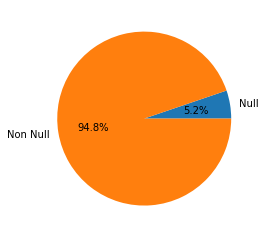

In [140]:
pie_data = []
pie_data.append(CustomerID_null['Quantity'].sum())
pie_data.append(CustomerID_notnull['Quantity'].sum())
plt.pie(pie_data, labels=['Null', 'Non Null'], autopct='%1.1f%%',)
plt.show()

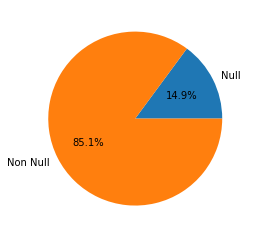

In [141]:
#To find the ratio of amount spent by null & not null customers
CustomerID_notnull['Total_Amount'] = CustomerID_notnull['Quantity']*CustomerID_notnull['UnitPrice']
CustomerID_null['Total_Amount'] = CustomerID_null['Quantity']*CustomerID_null['UnitPrice']
pie_data = []
pie_data.append(CustomerID_null['Total_Amount'].sum())
pie_data.append(CustomerID_notnull['Total_Amount'].sum())
plt.pie(pie_data, labels=['Null', 'Non Null'], autopct='%1.1f%%',)
plt.show()

In [142]:
# To analyse if any invoice intersects with the null/notnull CustomerID - Inference: None
intersect = pd.Series(np.intersect1d(CustomerID_null['InvoiceNo'].values, CustomerID_notnull['InvoiceNo'].values))
# intersect = pd.Series(np.intersect1d(CustomerID_null['Description_Code'].values, CustomerID_notnull['Description_Code'].values))
print(intersect.values)

[]


In [143]:
#Finding correlation between Country and other columns - pearson method
df.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Quantity,UnitPrice,CustomerID,Year,Month,Day,Hour,TotalPrice,Description_Code,Country_Code
Quantity,1.0,-0.39,-0.14,0.051,-0.023,0.0049,-0.21,0.69,0.022,-0.21
UnitPrice,-0.39,1.0,-0.013,-0.059,-0.0024,-0.0018,0.026,0.32,-0.0073,0.014
CustomerID,-0.14,-0.013,1.0,-0.036,0.032,-0.0025,0.056,-0.16,-0.0046,0.42
Year,0.051,-0.059,-0.036,1.0,-0.44,0.16,-0.0094,0.009,0.021,-0.03
Month,-0.023,-0.0024,0.032,-0.44,1.0,-0.15,0.027,-0.028,0.011,0.023
Day,0.0049,-0.0018,-0.0025,0.16,-0.15,1.0,0.00074,0.0039,0.0045,-0.0049
Hour,-0.21,0.026,0.056,-0.0094,0.027,0.00074,1.0,-0.2,-0.0067,0.12
TotalPrice,0.69,0.32,-0.16,0.009,-0.028,0.0039,-0.2,1.0,0.011,-0.21
Description_Code,0.022,-0.0073,-0.0046,0.021,0.011,0.0045,-0.0067,0.011,1.0,-0.016
Country_Code,-0.21,0.014,0.42,-0.03,0.023,-0.0049,0.12,-0.21,-0.016,1.0


In [144]:
#Correlation using Kendall's method
df.corr(method ='kendall').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1) 

,Quantity,UnitPrice,CustomerID,Year,Month,Day,Hour,TotalPrice,Description_Code,Country_Code
Quantity,1.0,-0.29,-0.098,0.044,-0.017,0.0035,-0.16,0.53,0.015,-0.17
UnitPrice,-0.29,1.0,-0.009,-0.049,-0.0016,-0.0013,0.019,0.24,-0.0069,0.011
CustomerID,-0.098,-0.009,1.0,-0.03,0.022,-0.0018,0.039,-0.11,-0.0031,0.34
Year,0.044,-0.049,-0.03,1.0,-0.38,0.13,-0.0081,0.0074,0.017,-0.029
Month,-0.017,-0.0016,0.022,-0.38,1.0,-0.11,0.02,-0.019,0.0074,0.02
Day,0.0035,-0.0013,-0.0018,0.13,-0.11,1.0,0.00056,0.0027,0.0031,-0.0039
Hour,-0.16,0.019,0.039,-0.0081,0.02,0.00056,1.0,-0.14,-0.0047,0.1
TotalPrice,0.53,0.24,-0.11,0.0074,-0.019,0.0027,-0.14,1.0,0.0074,-0.17
Description_Code,0.015,-0.0069,-0.0031,0.017,0.0074,0.0031,-0.0047,0.0074,1.0,-0.013
Country_Code,-0.17,0.011,0.34,-0.029,0.02,-0.0039,0.1,-0.17,-0.013,1.0


In [0]:
#Creating X_train dataset
d={'Customer_ID': df['CustomerID'], 'Description': df['descriptioncode'], 'Quantity': df['Quantity'], 'Unit_Price': df['UnitPrice']}
X = pd.DataFrame(d)

In [0]:
#Creating Y_train dataset
y_d = {'Country': df['countrycode']}
Y=pd.DataFrame(y_d)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Splitting the dataset: 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0)

In [0]:
#Decision Tree
decision_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
decision_predictions = decision_model.predict(X_test) 
  
# creating a confusion matrix 
decision_cm = confusion_matrix(y_test, decision_predictions) 
#Returning accuracy score
decision_accuracy = accuracy_score(y_test, decision_predictions)
print(decision_accuracy)

0.9157279309967032


In [0]:
# Support Vector Machine
svm_model= SVC(kernel = 'linear').fit(X_train, y_train) 
svm_predictions = svm_model.predict(X_test) 
  
# model accuracy for X_test   
svm_accuracy = svm_model.score(X_test, y_test)  
# creating a confusion matrix 
svm_cm = confusion_matrix(y_test, svm_predictions) 
print(svm_accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#K-NN

knn_model = KNeighborsClassifier().fit(X_train, y_train)

# creating a confusion matrix 
knn_predictions = knn_model.predict(X_test)  
knn_cm = confusion_matrix(y_test, knn_predictions) 

# accuracy on X_test 
knn_accuracy = knn_model.score(X_test, y_test) 
print(knn_accuracy) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.9589047917849424


In [0]:
#Naive-Bayes

nb_model = GaussianNB().fit(X_train, y_train) 
gnb_predictions = nb_model.predict(X_test) 

# accuracy on X_test 
nb_accuracy = nb_model.score(X_test, y_test) 
print(nb_accuracy) 

# creating a confusion matrix 
nb_cm = confusion_matrix(y_test, gnb_predictions) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7237776516170158
